# Context and Description

In modern times, and in the video game industry the biggest trend that came about is the battle royale genere, where individuals or teams combat against each other in large maps often designed as island or specific city with segmented regions, in which an accumalated number of 100 participants battle each other by elimination and survival to be last standing and win the game. The specific game we are going is called "PlayerUnknown's Battlegrounds" and it one of the most popular example of battle-royale games, having sold over  75 million copies since its launch.

As a data scientist, we can analyze availabe data related to player's post stats for the game and his various achievements with the match played, as a means to discover relations, uncover patterns, and gain meaningful inference related to winning more games in PUBG and finding remarks worth mentioning for recommendations on how to play the game properly and more competitively.

We will also try to build a winning placement estimator via a machine learning approach, that predicts how likely you are to win a game based on your win placement score estimated. players can use this to check whether or not their current stats are good enough for winning games or if there is more leeway for improvement and training?

**About Data:**
- each row contains one player's post-game stats
- create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)

**Column Descriptions:** 
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dask import dataframe as dd
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


While Pandas is perfect for small to medium-sized datasets, larger ones are problematic. we can see that running the above cell takes a long time to run.

In [2]:
dtypes = {
        'assists'           : 'uint8',
        'boosts'            : 'uint8',
        'damageDealt'       : 'float32',
        'DBNOs'             : 'uint8',
        'headshotKills'     : 'uint8', 
        'heals'             : 'uint8',    
        'killPlace'         : 'uint8',    
        'killPoints'        : 'uint16',    
        'kills'             : 'uint8',    
        'killStreaks'       : 'uint8',    
        'longestKill'       : 'float32',
        'matchDuration'     : 'uint8',
        'maxPlace'          : 'uint8',    
        'numGroups'         : 'uint8',    
        'rankPoints'        : 'uint8',
        'revives'           : 'uint8',    
        'rideDistance'      : 'float32',    
        'roadKills'         : 'uint8',    
        'swimDistance'      : 'float32',    
        'teamKills'         : 'uint8',    
        'vehicleDestroys'   : 'uint8',    
        'walkDistance'      : 'float32',    
        'weaponsAcquired'   : 'uint8',    
        'winPoints'         : 'uint8', 
        'winPlacePerc'      : 'float32' 
}

In [3]:
dfd = pd.read_csv("../Data/raw_data/train_V2.csv", dtype=dtypes)

for memory optimization, we specify the columns data types during the import (via the dtype= input parameter). That way, we can force Pandas to convert some values into types with a significantly lower memory footprint.

**NOTE** We have 4 categorical features and 25 numerical features. however, due to the size of the data, some of the data types can be better formatted to take less space by using less resource-demanding data types (from int64 -> int16)

# 1- Exploratory Data Analysis

### 1.1 general data overview

In [4]:
dfd.head(5).T

,0,1,2,3,4
Id,7f96b2f878858a,eef90569b9d03c,1eaf90ac73de72,4616d365dd2853,315c96c26c9aac
groupId,4d4b580de459be,684d5656442f9e,6a4a42c3245a74,a930a9c79cd721,de04010b3458dd
matchId,a10357fd1a4a91,aeb375fc57110c,110163d8bb94ae,f1f1f4ef412d7e,6dc8ff871e21e6
assists,0,0,1,0,0
boosts,0,0,0,0,0
damageDealt,0.0,91.470001,68.0,32.900002,100.0
DBNOs,0,0,0,0,0
headshotKills,0,0,0,0,0
heals,0,0,0,0,0
killPlace,60,57,47,75,45


In [5]:
dfd.shape

(4446966, 29)

**NOTE** the data is fairly large in size, indicated by the number of records shown by shape (approximately 4.5 million records). there is also a sizable number of features, but not too many to the detriment of the computation of the data, unlike in high-dimensional cases. 

In [6]:
dfd.columns.tolist()

['Id',
 'groupId',
 'matchId',
 'assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchType',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

**INSIGHTS** we can see features related to unique identification, player stats, overall rewards and placements within the match. with winPlacePerc being the main dependant feature for the regression task.

In [7]:
dfd.dtypes 

Id                  object
groupId             object
matchId             object
assists              uint8
boosts               uint8
damageDealt        float32
DBNOs                uint8
headshotKills        uint8
heals                uint8
killPlace            uint8
killPoints          uint16
kills                uint8
killStreaks          uint8
longestKill        float32
matchDuration        uint8
matchType           object
maxPlace             uint8
numGroups            uint8
rankPoints           uint8
revives              uint8
rideDistance       float32
roadKills            uint8
swimDistance       float32
teamKills            uint8
vehicleDestroys      uint8
walkDistance       float32
weaponsAcquired      uint8
winPoints            uint8
winPlacePerc       float32
dtype: object

### 1.2 descriptive statistics

In [8]:
dfd.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.000000,0.000000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.000000,0.000000,2.000000,33.0
damageDealt,4446966.0,130.633118,169.886948,0.0,0.000000,84.239998,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.000000,0.000000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.000000,0.000000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.000000,0.000000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.000000,47.000000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.000000,0.000000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.000000,0.000000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.000000,0.000000,1.000000,20.0


**INSIGHTS**
- a lot of the numerical features have a minimum of 0
- high dispersion and standard deviation for some of the features
- some of the features have non symmetric distribution, indicating by the value jump from quartiles with each of those features. this also means that there might be outliers and extreme values that affect the data distribution
- rankPoints is the only feature with negative values
- data needs to be standardized as some features have small range of values and some have large range, which could affect the training process for the model.

In [9]:
dfd.describe(include='object') 

,Id,groupId,matchId,matchType
count,4446966,4446966,4446966,4446966
unique,4446966,2026745,47965,16
top,7f96b2f878858a,14d6b54cdec6bc,4b5db40aec4797,squad-fpp
freq,1,74,100,1756186


**INSIGHTS** 
- matchType is the only potential feature of interest for model training, as ID features aren't generally of valuable use when training models.
- groupId and matchId can be utilized as grouping columns when analyzing or exploring data.

### 1.3 Null values

In [10]:
dfd.isnull().sum() 

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

**NOTE** winPlacePerc has 1 missing value. so overall, there is only one records with missing values present in the training data.

In [11]:
dfd_mv_rows = dfd[dfd['winPlacePerc'].isna()]
dfd_mv_rows_index = dfd_mv_rows.index[0]
dfd_mv_rows_index

2744604

In [12]:
dfd = dfd.drop([dfd_mv_rows_index]).reset_index(drop=True)

In [13]:
dfd.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

### 1.4 duplicate values

In [14]:
duplicates = dfd[dfd.duplicated()]
print(f'number of duplicate values: {duplicates.shape[0]}')

number of duplicate values: 0


**INSIGHT** there are no duplicate rows in the data

### 1.5 numeric data distributions

In [15]:
dfd_num_cols = dfd.dtypes[dfd.dtypes != 'object'].index.tolist()
dfd_cate_cols = dfd.dtypes[dfd.dtypes == 'object'].index.tolist()

In [28]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_data = dfd[dfd_num_cols]
num_data
# num_data.compute()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.000000,0,0,0,60,1241,0,0,...,0,0.0000,0,0.000,0,0,244.800003,1,186,0.4444
1,0,0,91.470001,0,0,0,57,0,0,0,...,0,0.0045,0,11.040,0,0,1434.000000,5,0,0.6400
2,1,0,68.000000,0,0,0,47,0,0,0,...,0,0.0000,0,0.000,0,0,161.800003,2,0,0.7755
3,0,0,32.900002,0,0,0,75,0,0,0,...,0,0.0000,0,0.000,0,0,202.699997,3,0,0.1667
4,0,0,100.000000,0,0,0,45,0,1,1,...,0,0.0000,0,0.000,0,0,49.750000,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446960,0,0,0.000000,0,0,0,74,1029,0,0,...,0,1292.0000,0,0.000,0,0,1019.000000,3,227,0.1786
4446961,0,1,44.150002,0,0,0,69,0,0,0,...,0,0.0000,0,0.000,0,0,81.699997,6,0,0.2935
4446962,0,0,59.060001,0,0,0,66,0,0,0,...,0,0.0000,0,2.184,0,0,788.700012,4,0,0.4815
4446963,0,4,180.399994,1,1,2,11,0,2,1,...,2,0.0000,0,0.000,0,0,2748.000000,8,0,0.8000


In [17]:
num_data.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.000000,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.800003,1,186,0.4444
1,0,0,91.470001,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1,0,68.000000,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,0,0,32.900002,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,0,0,100.000000,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


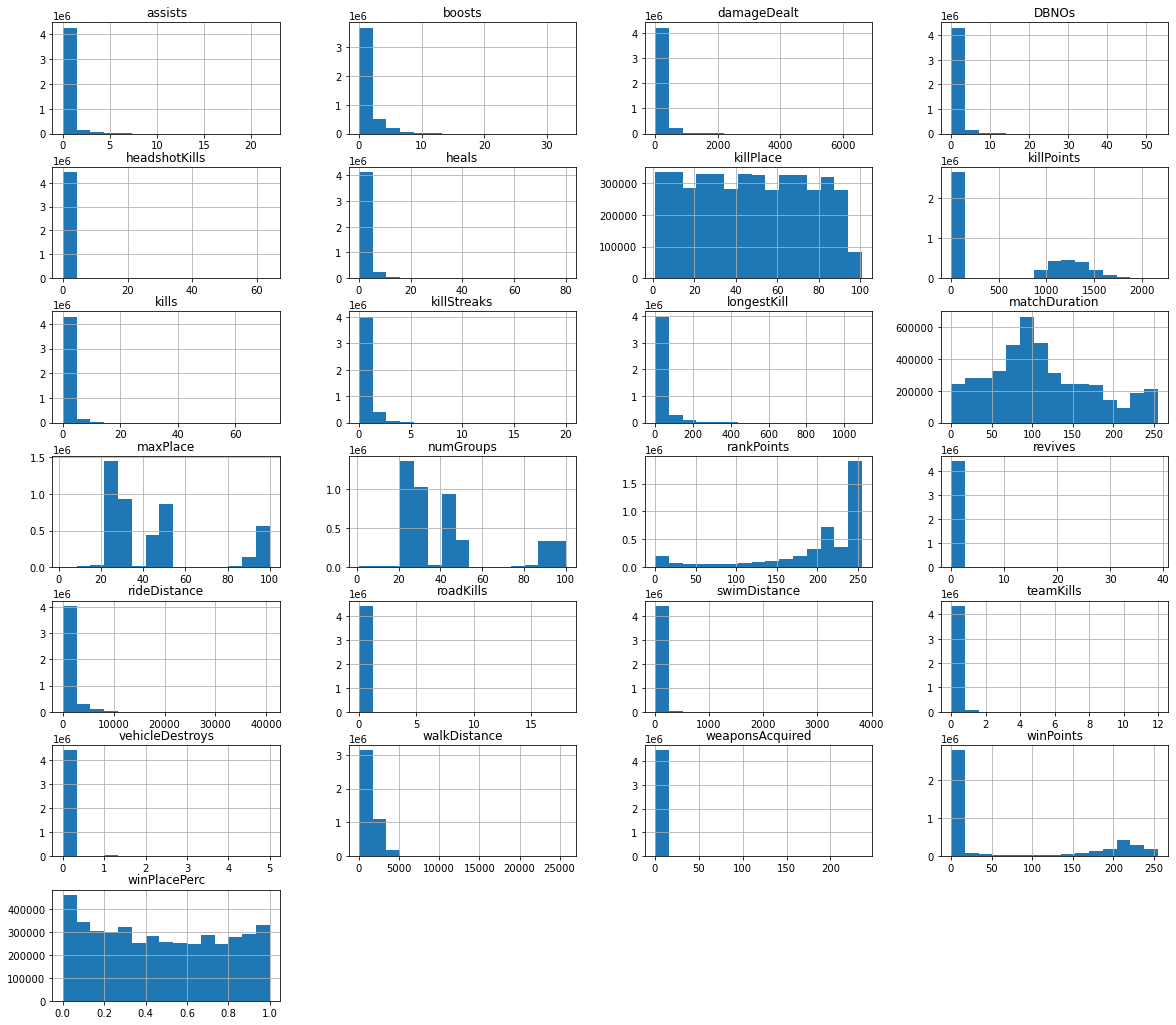

In [18]:
num_data.hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributinos')
plt.show()

**INSIGHT** the data is highly skewed (mostly right-skewed), which presents a potential bias problem in the data if it is not handled correctly. possible solutions are removing data transformation methods and outlier removals.

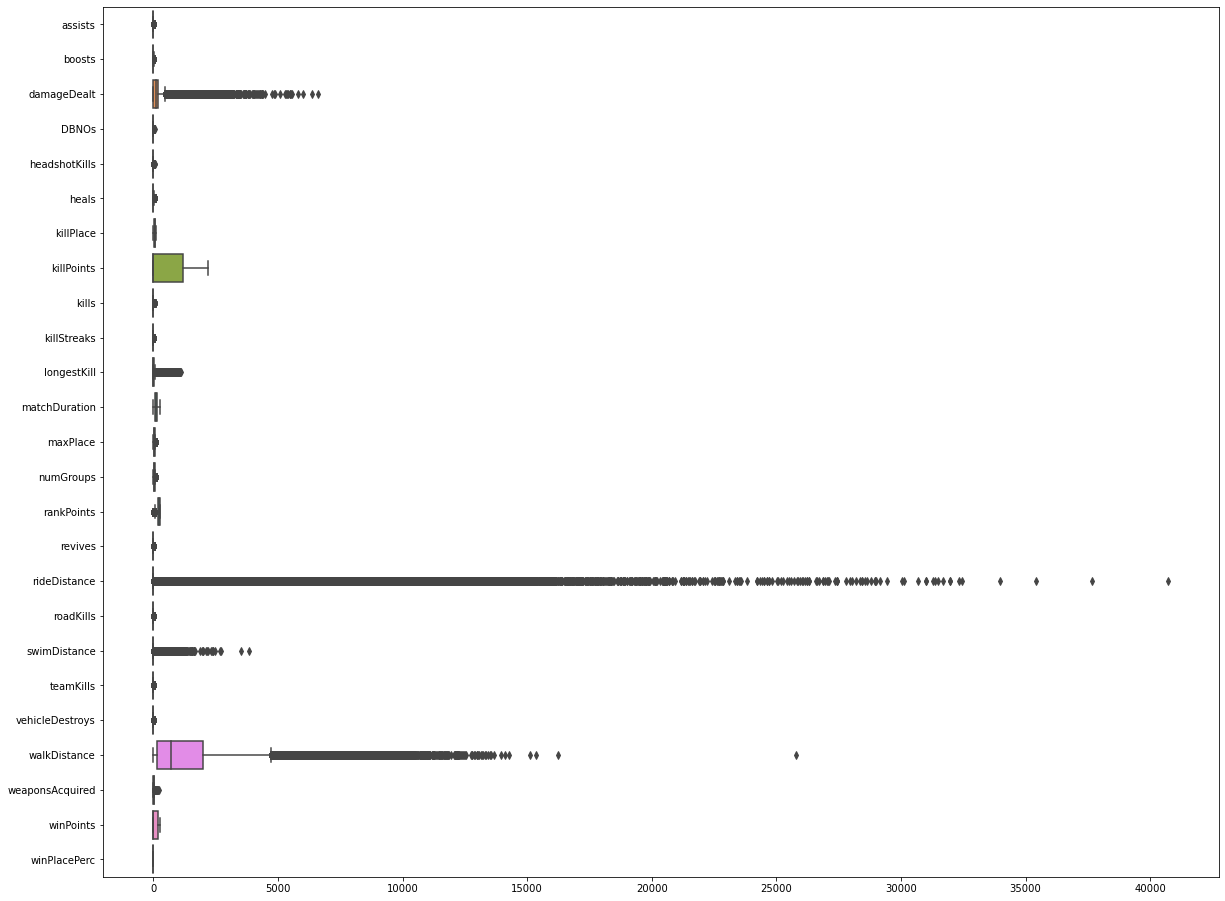

In [19]:
# Original Dataframe
plt.figure(figsize=(20,16))
sns.boxplot(data=num_data, orient='h')
plt.show()

**INSIGHT** this shows that data is not standardized and confirms the presence of outliers present with the data. outliers specifically might be a direct cause of the data skewness.

### 1.6 correlations

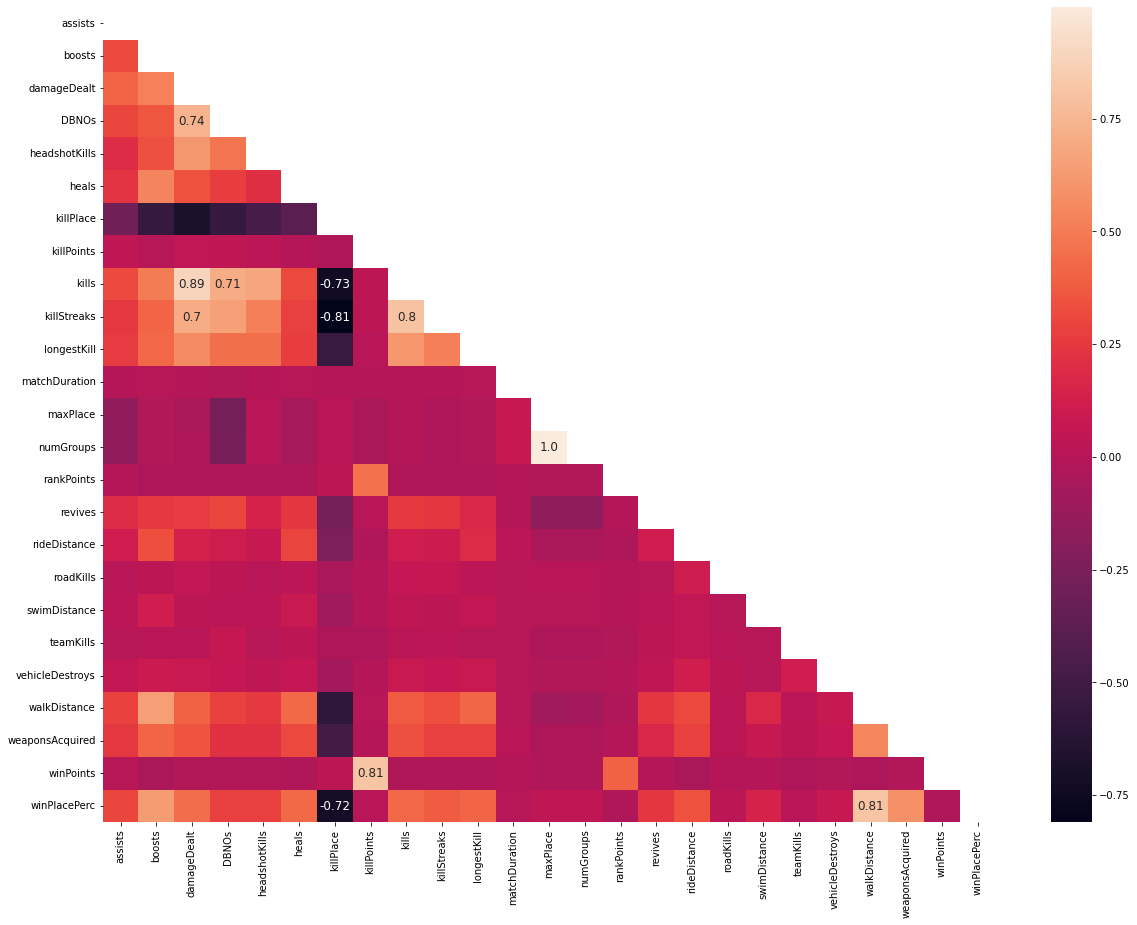

In [31]:
# The correlation matrix
corr_mat = num_data.corr()

# Strip out the diagonal values for the next step
for x in range(len(list(num_data.columns))):
    corr_mat.iloc[0:x+1,x] = 0.0

labels = corr_mat.applymap(lambda v: str(round(v, 2)) if abs(v) > 0.7 else '')  

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(20,15))
sns.heatmap(corr_mat, annot=labels, mask=mask, annot_kws={'fontsize':12})
plt.show()

**INSIGHTS**
- there is multicollinearity in the data
- high positve correlations: (DBNOs/damageDealt), (kills/damageDealt), (killStreaks/damageDealt), (kills/DBNOs), (winPoints/killPoints), (killStreaks, Kills), (numGroups/maxPlace), (winPlacePerc/walkDistance)
- high negative correlations: (kills/killPlace), (killStreaks/killPlace), (winPlacePerc/killPlace), (rankPoints/killPoints), (winPoints/rankPoints)

In [50]:
# Pairwise maximal correlations
print('--> highest correlated pairs')
pair_corr = pd.DataFrame()
pair_corr['col1'] = corr_mat.abs().idxmax()
pair_corr['col2'] = corr_mat.abs().idxmax().index
pair_corr['corr_score'] = corr_mat.abs().max()
# display(pair_corr[pair_corr['corr_score'] > 0.50])
display(pair_corr[pair_corr['corr_score'] > 0.70])

--> highest correlated pairs


,col1,col2,corr_score
damageDealt,kills,damageDealt,0.888783
DBNOs,kills,DBNOs,0.707848
killPlace,killStreaks,killPlace,0.810517
killPoints,winPoints,killPoints,0.809374
kills,killStreaks,kills,0.802500
maxPlace,numGroups,maxPlace,0.997900
walkDistance,winPlacePerc,walkDistance,0.810888


### 1.7 categorical data distributions

In [32]:
cate_data = dfd.select_dtypes(exclude=numerics)
cate_cols = cate_data.columns
cate_data.head()

,Id,groupId,matchId,assists,boosts,DBNOs,headshotKills,heals,killPlace,killPoints,...,matchType,maxPlace,numGroups,rankPoints,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0,0,0,60,1241,...,squad-fpp,28,26,255,0,0,0,0,1,186
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,0,0,0,57,0,...,squad-fpp,26,25,204,0,0,0,0,5,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,0,0,0,47,0,...,duo,50,47,211,0,0,0,0,2,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,0,0,0,75,0,...,squad-fpp,31,30,128,0,0,0,0,3,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,0,0,0,45,0,...,solo-fpp,97,95,24,0,0,0,0,2,0


In [53]:
# id value counts
vcs = cate_data['Id'].value_counts()
vcs[vcs > 1]

Series([], Name: Id, dtype: int64)

**NOTE** not worth encoding, this feature will not be used in model trainig

In [57]:
# id value counts
vcs = cate_data['groupId'].value_counts()
vcs[vcs > 1]

14d6b54cdec6bc    74
b8275198faa03b    72
128b07271aa012    64
7385e5fe214021    49
e52a2e6ca30474    36
                  ..
4caf0873692e9e     2
d8257d55f4734d     2
544b7f16f8801d     2
84a29cf7906637     2
0c5aa8a0bc1160     2
Name: groupId, Length: 1234468, dtype: int64

**NOTE** useful for aggregation and analysis, but this feature not used for model training, as it is ID information.

In [58]:
# id value counts
vcs = cate_data['matchId'].value_counts()
vcs[vcs > 1]

4b5db40aec4797    100
b10e8738adafb9    100
bc28c54250342d    100
c2db47653f79b7    100
79e05d7908e0ca    100
                 ... 
f491e7a7e2ff47      7
9f2b49358564ea      6
39d2800dad8ae6      6
8aa5066c4b6a79      5
e5a77433bc436f      2
Name: matchId, Length: 47964, dtype: int64

**NOTE** useful for aggregation and analysis, but this feature not used for model training, as it is ID information.

In [59]:
for col in cate_data.columns:
    unique_vals = cate_data[col].nunique()
    print(f'feature ({col}): {unique_vals} unique values')

feature (Id): 4446965 unique values
feature (groupId): 2026744 unique values
feature (matchId): 47964 unique values
feature (assists): 20 unique values
feature (boosts): 27 unique values
feature (DBNOs): 39 unique values
feature (headshotKills): 34 unique values
feature (heals): 63 unique values
feature (killPlace): 101 unique values
feature (killPoints): 1707 unique values
feature (kills): 58 unique values
feature (killStreaks): 18 unique values
feature (matchDuration): 256 unique values
feature (matchType): 16 unique values
feature (maxPlace): 99 unique values
feature (numGroups): 100 unique values
feature (rankPoints): 256 unique values
feature (revives): 25 unique values
feature (roadKills): 14 unique values
feature (teamKills): 11 unique values
feature (vehicleDestroys): 6 unique values
feature (weaponsAcquired): 97 unique values
feature (winPoints): 256 unique values


**NOTE** We're going to show values by matchType, as knowing distribution of games by their types might provide with valuable information. we're not going to show for ID features(Id, groupId, matchId) as that only shows the uniqueness of each group, entity, or match, and checking their distributions does not indicate any further useful insight.

In [60]:
# mt: match type
print(f"Match Types in the data:")

match_types = cate_data['matchType'].unique().tolist()
for i, mt in enumerate(match_types):
    print(f" {i+1}- {mt}")

Match Types in the data:
 1- squad-fpp
 2- duo
 3- solo-fpp
 4- squad
 5- duo-fpp
 6- solo
 7- normal-squad-fpp
 8- crashfpp
 9- flaretpp
 10- normal-solo-fpp
 11- flarefpp
 12- normal-duo-fpp
 13- normal-duo
 14- normal-squad
 15- crashtpp
 16- normal-solo


In [62]:
match_types_agg = cate_data["matchType"].value_counts().to_frame() 

display(match_types_agg)

,matchType
squad-fpp,1756186
duo-fpp,996691
squad,626526
solo-fpp,536761
duo,313591
solo,181943
normal-squad-fpp,17174
crashfpp,6287
normal-duo-fpp,5489
flaretpp,2505


**NOTE** this features must later be encoded for model training purposes.

**INSIGHT** we can see that squad modes in general (squad-fpp, squad, normal-squad) are the most picked type of matches

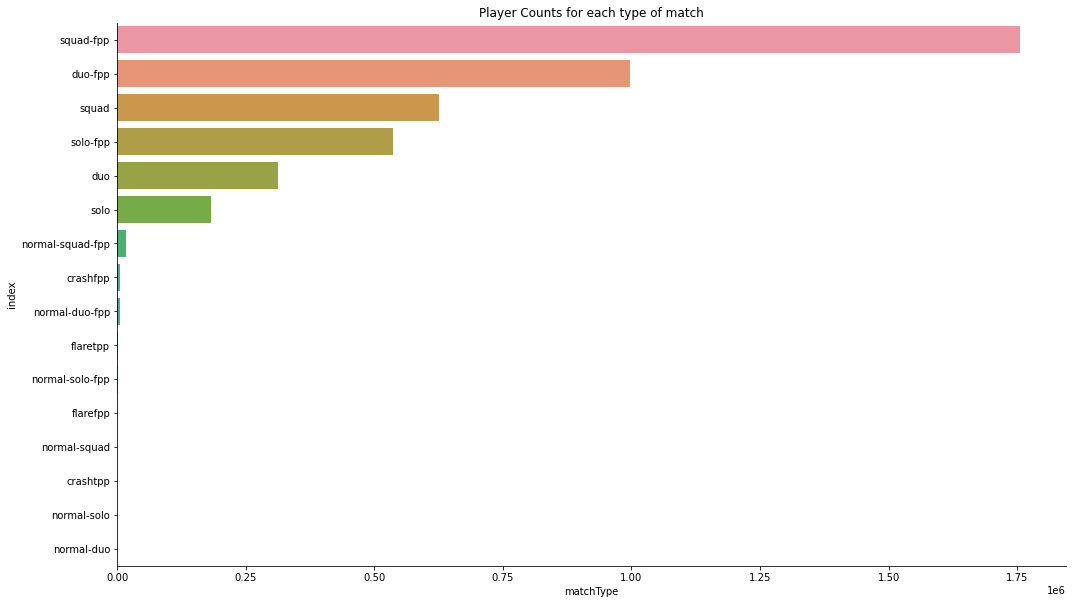

In [63]:
# visualization showing distrubtion across category features
sns.catplot(data=match_types_agg.reset_index(), y='index', x='matchType', kind='bar', ci=None, height=8.27, aspect=15/8.27)
plt.title('Player Counts for each type of match')
plt.show()

**INSIGHT** this further verifes that squad modes are the most picked type of matches

<hr>

# 2- Analysis

In [117]:
dfd['player_count'] = 1

In [151]:
avg_match_types = dfd.groupby(['matchType']).mean()
avg_match_types.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_count
matchType,,,,,,,,,,,,,,,,,,,,,
crashfpp,0.191824,1.131223,90.026154,0.452839,0.075553,1.207253,44.945920,0.000000,0.779068,0.516781,...,1890.569458,0.312868,1.543515,0.073167,0.078098,669.118958,1.518530,0.000000,0.474711,1.0
crashtpp,0.242588,1.105121,101.932503,0.479784,0.056604,0.940701,38.417790,0.000000,0.881402,0.576819,...,1302.812012,0.366577,0.294717,0.037736,0.067385,724.213013,1.665768,0.000000,0.484515,1.0
duo,0.213676,1.133486,126.321991,0.610553,0.212576,1.338989,47.408660,443.144156,0.907966,0.545258,...,752.369873,0.004260,4.811172,0.026187,0.010431,1123.632446,3.719144,67.888406,0.482777,1.0
duo-fpp,0.215806,1.078022,132.249542,0.628594,0.225009,1.328823,47.638865,485.647968,0.926086,0.566743,...,546.374146,0.002020,4.178060,0.019369,0.005852,1104.370605,3.564324,66.896088,0.485801,1.0
flarefpp,0.278552,1.316156,138.440872,0.891365,0.204735,1.835655,41.564067,0.000000,0.885794,0.543175,...,1323.506836,0.008357,3.023554,0.044568,0.022284,1497.557739,4.473538,0.000000,0.451455,1.0


In [242]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [245]:
# importing processed data for specific uses (when standardized data is needed for visualization)
dfd_cle_RR_viz_pow = reduce_mem_usage(pd.read_csv('../Data/processed/dfd_cle_RR_viz_pow.csv'))
dfd_cle_RR_viz_pow.head()

Memory usage of dataframe is 1006.81 MB
Memory usage after optimization is: 360.77 MB
Decreased by 64.2%


### 2.1 Simple Analysis

In [33]:
# How many players are there per match ?
matches_mean = cate_data.groupby(['matchId']).count()['Id'].mean()
avg_player_per_match = round(matches_mean)
print(f'average number of players in one match: {avg_player_per_match}')

average number of players in one match: 93


In [38]:
# average number of kills 
# matches_mean = cate_data.groupby(['groupId']).mean()['kills'].mean()
# avg_player_per_match = round(matches_mean)
print("average number of kills: {:.3f}".format(cate_data['kills'].mean()))

average number of kills: 0.925


In [35]:
# average number of kills per team
team_kill_mean = cate_data.groupby(['groupId']).mean()['kills'].mean()
avg_kills_per_team = round(team_kill_mean)
print(f'average number of players in one match: {avg_kills_per_team}')

average number of players in one match: 1


### 2.2 How many players per group on average on different main modes (squad, duo, solo)?

In [145]:
avg_player_num_per_group = dfd[['player_count', 'matchType', 'matchId', 'groupId']].groupby(['matchType', 'matchId', 'groupId']).sum()
avg_player_num_per_group = avg_player_num_per_group.reset_index().groupby(['matchType']).mean()
avg_player_num_per_group

,player_count
matchType,
crashfpp,2.008626
crashtpp,2.061111
duo,2.058710
duo-fpp,2.048735
flarefpp,3.590000
flaretpp,3.604317
normal-duo,1.970297
normal-duo-fpp,1.949911
normal-solo,1.405172


**NOTE** some averages are a bit higher than expected (E.g. duo-fpp is higher than 2), this is mostly because:
- Revives done by teammates or self-revives that allow the player to start again, making it seem like 3 or more player are in the duo based on those revives.
- Player Replacements during the game for some of the modes.

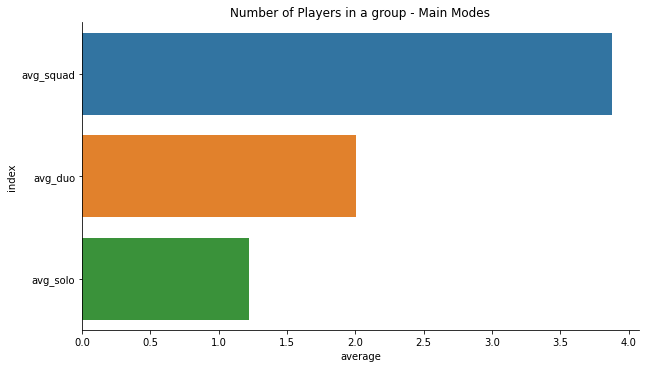

In [190]:
avg_squad = avg_player_num_per_group.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"player_count"].mean()
# avg_squad = avg_player_num_per_group.xs(["squad-fpp","squad","normal-squad-fpp","normal-squad"], level='matchType', drop_level=False).mean()

avg_duo = avg_player_num_per_group.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"player_count"].mean()
avg_solo = avg_player_num_per_group.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"player_count"].mean()
mt_avg = pd.DataFrame([avg_squad, avg_duo, avg_solo], index=["avg_squad","avg_duo","avg_solo"], columns =["average"])

sns.catplot(data=mt_avg.reset_index(), y='index', x='average', kind='bar', ci=None, height=5, aspect=15/8.27)
plt.title('Number of Players in a group - Main Modes')
plt.show()
# avg_squad

**INSIGHT** we can see that most groups for each player-group is nearly filled-out on average. so most groups for squad game modes are slightly less than target (4), and duo-mode groups are also filled-out on average, and the same for solo groups.



### 2.3 Which type of player-group do players generally prefer playing in? 

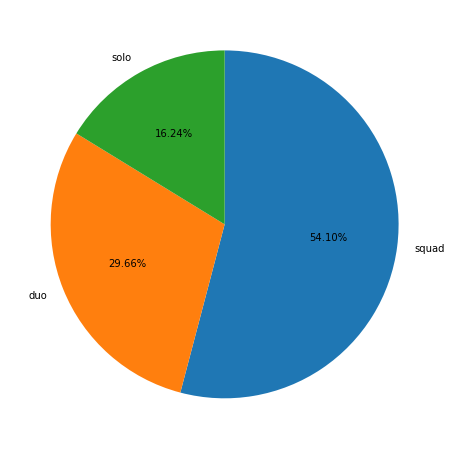

In [67]:
# which types of player groups do player generally prefer playing in? 
# mt: main types
squads = match_types_agg.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
duos = match_types_agg.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
solo = match_types_agg.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
mt = pd.DataFrame([squads, duos, solo], index=["squad","duo","solo"], columns =["count"])

labels = ['squad', 'duo', 'solo']
frequency = pd.Series.tolist(mt['count'])

fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.pie(frequency, 
       labels=labels, 
       startangle=90, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p)
       )
 
plt.show()

**CONCLUSION 1** squad-type game modes are the most picked type of match, followed by duo-modes, followed by solo-modes. there is a tendancy among players to play in squads.


### 2.4 How many kills do most players get per game?

In [163]:
dfd[dfd_num_cols]['kills'].value_counts()

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2
49          1
45          1
47          1
48          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


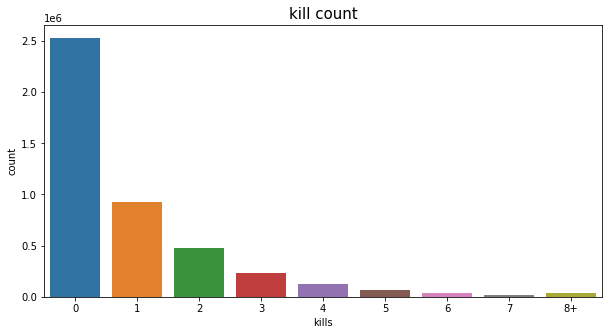

In [188]:
data=dfd.copy()
data.loc[data['kills']>data['kills'].quantile(0.99)]='8+'
plt.figure(figsize=(10,5))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("kill count",fontsize=15)
plt.show()

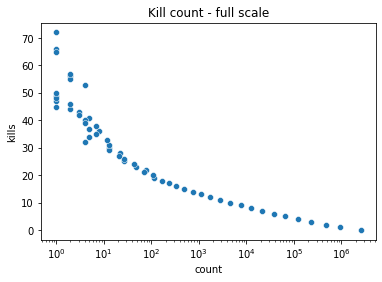

In [39]:
kills_vcs = pd.DataFrame(dfd[dfd_num_cols]['kills'].value_counts()).reset_index().rename(columns={'index': 'kills', 'kills': 'count'})

p = sns.scatterplot(data= kills_vcs, x='count', y='kills')
p.set(xscale='log')
plt.title('Kill count - full scale')
plt.show()

**INSIGHT** we can see that there are less players getting high number of kills per game, with very few players reaching the mark of 20 and above.

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


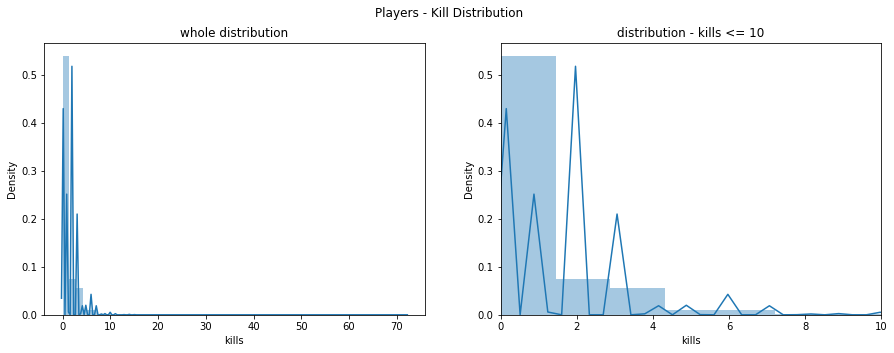

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Players - Kill Distribution')

p = sns.distplot(dfd['kills'], ax=axes[0])
axes[0].set_title("whole distribution")

p = sns.distplot(dfd['kills'], ax=axes[1])
axes[1].set_title("distribution - kills <= 10")
p.set(xlim=(0, 10))

plt.show()

**INSIGHT** the overwhelming majority of players don't get more than 4 kills per game.

In [170]:
print(f"average number of kills per player: {dfd['kills'].mean()}")

average number of kills per player: 0.9247835321393355


**INSIGHT** the average is affected by the high number players getting 0 kills. this also shown in the graphs above for kill distriubtion.

**CONCLUSION 2** in each game, a lot of players don't get kills, some player get a few kills (usually <= 4), and a handful of players get more than that per game.

### 2.5 Which game mode is the easiest to win at?

In [157]:
avg_match_types

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_count
matchType,,,,,,,,,,,,,,,,,,,,,
crashfpp,0.191824,1.131223,90.026154,0.452839,0.075553,1.207253,44.945920,0.000000,0.779068,0.516781,...,1890.569458,0.312868,1.543515,0.073167,0.078098,669.118958,1.518530,0.000000,0.474711,1.0
crashtpp,0.242588,1.105121,101.932503,0.479784,0.056604,0.940701,38.417790,0.000000,0.881402,0.576819,...,1302.812012,0.366577,0.294717,0.037736,0.067385,724.213013,1.665768,0.000000,0.484515,1.0
duo,0.213676,1.133486,126.321991,0.610553,0.212576,1.338989,47.408660,443.144156,0.907966,0.545258,...,752.369873,0.004260,4.811172,0.026187,0.010431,1123.632446,3.719144,67.888406,0.482777,1.0
duo-fpp,0.215806,1.078022,132.249542,0.628594,0.225009,1.328823,47.638865,485.647968,0.926086,0.566743,...,546.374146,0.002020,4.178060,0.019369,0.005852,1104.370605,3.564324,66.896088,0.485801,1.0
flarefpp,0.278552,1.316156,138.440872,0.891365,0.204735,1.835655,41.564067,0.000000,0.885794,0.543175,...,1323.506836,0.008357,3.023554,0.044568,0.022284,1497.557739,4.473538,0.000000,0.451455,1.0
flaretpp,0.284232,1.364471,128.363312,0.857086,0.192016,1.840719,44.145709,113.373253,0.857485,0.505788,...,1610.638184,0.010778,6.772103,0.054691,0.031138,1442.506592,4.346108,24.942116,0.434591,1.0
normal-duo,1.155779,1.075377,441.994415,2.457286,0.924623,2.758794,10.713568,663.316583,3.829146,0.944724,...,1351.141724,0.030151,0.937136,0.035176,0.020101,1212.131714,10.633166,145.929648,0.514656,1.0
normal-duo-fpp,0.609583,1.688832,253.990265,0.877209,0.472946,2.305338,25.502459,673.346693,1.956094,0.682456,...,1757.459839,0.009656,7.500335,0.021133,0.017672,1618.029175,6.672254,148.136273,0.508175,1.0
normal-solo,1.745399,0.809816,799.843811,0.000000,1.920245,2.466258,10.684049,677.914110,7.509202,1.377301,...,399.189392,0.000000,1.980368,0.073620,0.000000,939.345154,18.279141,149.141104,0.561912,1.0


In [179]:
data_temp = avg_match_types.reset_index().sort_values(by=['winPlacePerc']).reset_index(drop=True)
data_temp

,matchType,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_count
0,flaretpp,0.284232,1.364471,128.363312,0.857086,0.192016,1.840719,44.145709,113.373253,0.857485,...,1610.638184,0.010778,6.772103,0.054691,0.031138,1442.506592,4.346108,24.942116,0.434591,1.0
1,flarefpp,0.278552,1.316156,138.440872,0.891365,0.204735,1.835655,41.564067,0.000000,0.885794,...,1323.506836,0.008357,3.023554,0.044568,0.022284,1497.557739,4.473538,0.000000,0.451455,1.0
2,squad,0.289891,1.175439,127.600204,0.854052,0.212073,1.508456,47.690383,496.643399,0.891428,...,789.878296,0.004460,5.049294,0.033994,0.012640,1252.594727,3.790926,68.587674,0.451908,1.0
3,squad-fpp,0.287245,1.107993,133.587585,0.872816,0.220646,1.476785,47.921326,556.643272,0.908386,...,581.604675,0.001967,4.219204,0.026919,0.007765,1232.484863,3.626464,71.725842,0.464764,1.0
4,solo,0.055616,1.066048,112.615135,0.000000,0.223823,1.012130,46.172224,407.839994,0.870932,...,640.980042,0.009948,5.878082,0.014994,0.007530,986.208313,3.757353,61.547869,0.473814,1.0
5,crashfpp,0.191824,1.131223,90.026154,0.452839,0.075553,1.207253,44.945920,0.000000,0.779068,...,1890.569458,0.312868,1.543515,0.073167,0.078098,669.118958,1.518530,0.000000,0.474711,1.0
6,duo,0.213676,1.133486,126.321991,0.610553,0.212576,1.338989,47.408660,443.144156,0.907966,...,752.369873,0.004260,4.811172,0.026187,0.010431,1123.632446,3.719144,67.888406,0.482777,1.0
7,crashtpp,0.242588,1.105121,101.932503,0.479784,0.056604,0.940701,38.417790,0.000000,0.881402,...,1302.812012,0.366577,0.294717,0.037736,0.067385,724.213013,1.665768,0.000000,0.484515,1.0
8,duo-fpp,0.215806,1.078022,132.249542,0.628594,0.225009,1.328823,47.638865,485.647968,0.926086,...,546.374146,0.002020,4.178060,0.019369,0.005852,1104.370605,3.564324,66.896088,0.485801,1.0
9,solo-fpp,0.057640,1.058980,118.918800,0.000000,0.251553,1.009678,48.025596,460.651884,0.934731,...,403.209686,0.003488,4.824648,0.010183,0.003499,945.309082,3.486528,62.341837,0.491835,1.0


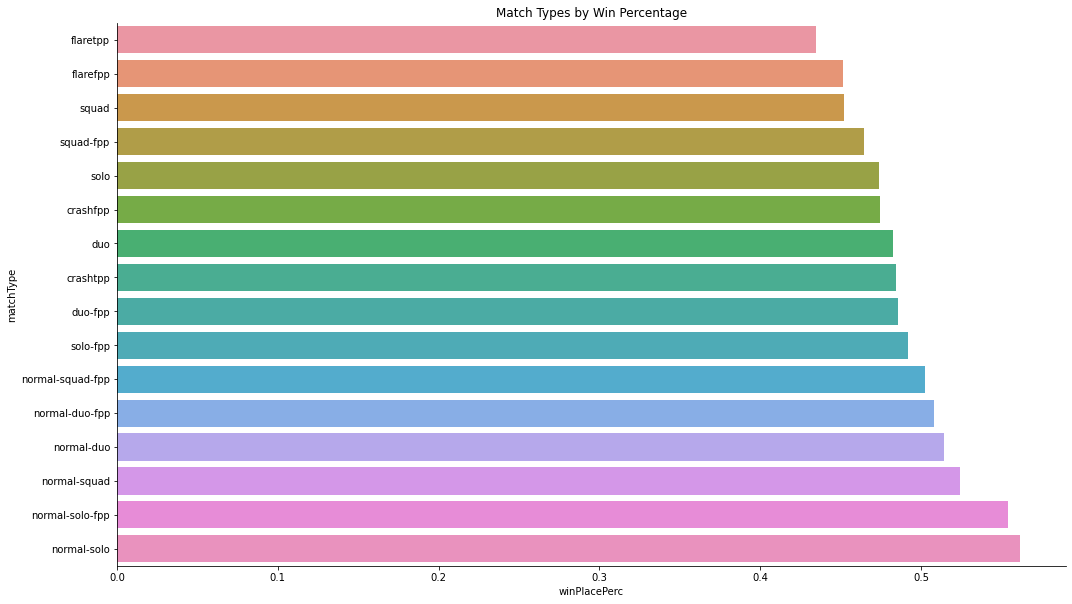

In [182]:
# data_temp = avg_match_types.reset_index().sort
sns.catplot(data=data_temp, y='matchType', x='winPlacePerc',
            kind='bar', ci=None, height=8.27, aspect=15/8.27 )
plt.title('Match Types by Win Percentage')
plt.show()

**CONCLUSION 3** playing normal solo games seems to be the easiest to win, as winning percentile for it is the highest. however, the difference in winning percentile among all gamemodes is rather non-sizable, indicating that there are other factor that account for winning games

### 2.6 Does utilizing heals and boosts contribute to winning games?

In [40]:
data=dfd.copy()

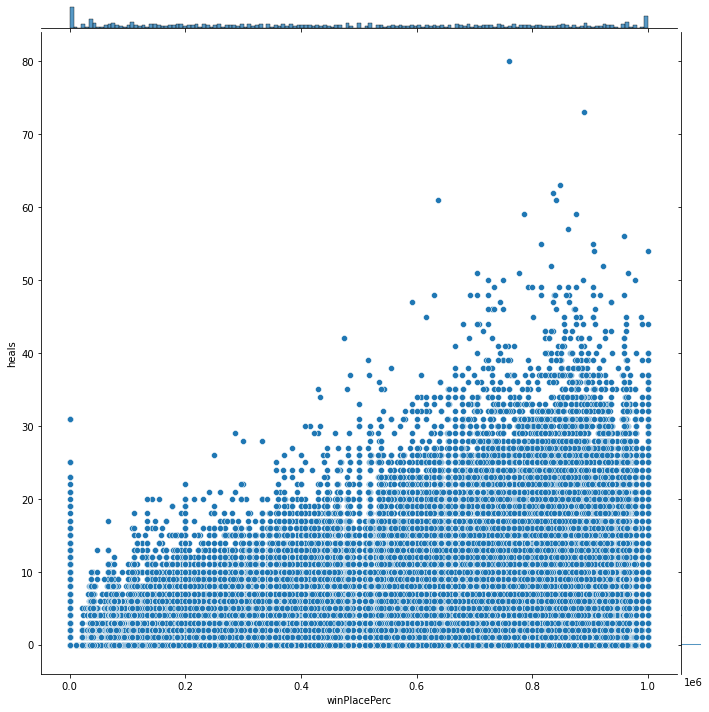

In [201]:
sns.jointplot(x='winPlacePerc', y='heals', data=data, height=10, ratio=25)
plt.title()
plt.show()

**INSIGHT** there seems to be a positive relationship between winning games and utilizing healing items.

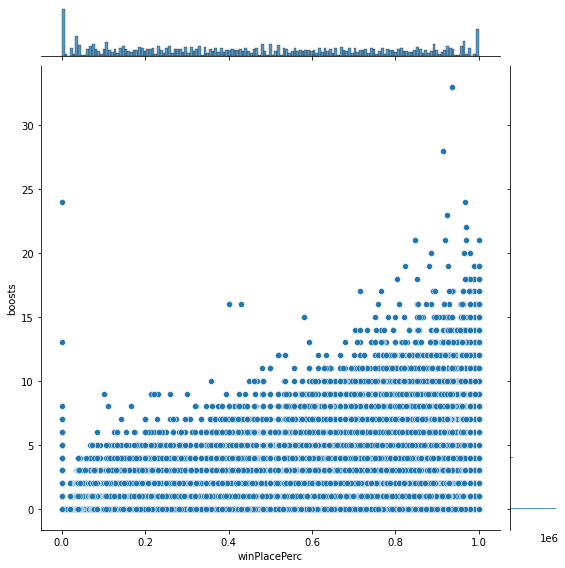

In [26]:
sns.jointplot(x='winPlacePerc', y='boosts', data=data, height=8, ratio=8)
plt.show()

**INSIGHT** there seems to be a positive relationship between winning games and utilizing boost items

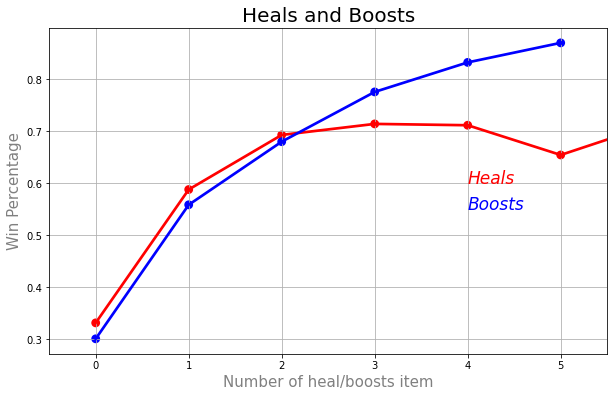

In [204]:
data=data[data['heals']<data['heals'].quantile(0.99)]
data=data[data['boosts']<data['boosts'].quantile(0.99)]
f, ax1=plt.subplots(figsize=(10,6))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='red',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='red',fontsize=17,style='italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize=17,style='italic')
plt.xlabel('Number of heal/boosts item',fontsize=15,color='gray')
plt.ylabel('Win Percentage',fontsize=15,color='gray')
plt.title('Heals and Boosts',fontsize=20, color='black')
plt.grid()
plt.show()

**CONCLUSION 4** in conclusion, to increase your chances of winning games, you have to use utilize boost items and healing items effectively.

### 2.7 Does eliminating more players contribute to winning games?

**Features:** DBNOs, killPlace, killPoints, killStreaks, kills, longestKill, roadKills

In [44]:
data = dfd.copy()
cols_temp = ['DBNOs', 'killPlace', 'killPoints', 'killStreaks', 'kills', 'longestKill', 'roadKills']

**NOTE** using transformed features as they are more standadized

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


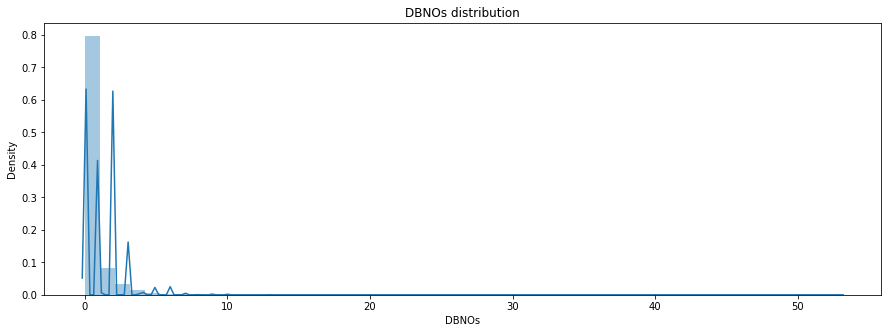

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


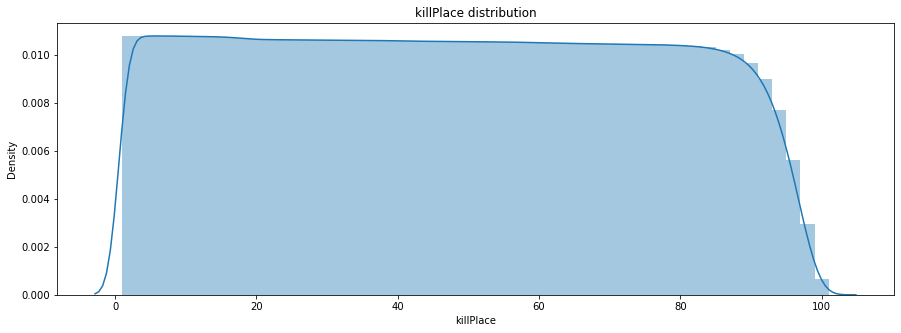

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


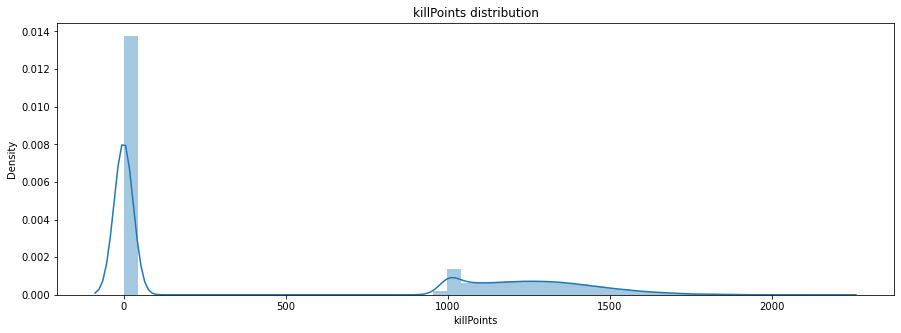

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


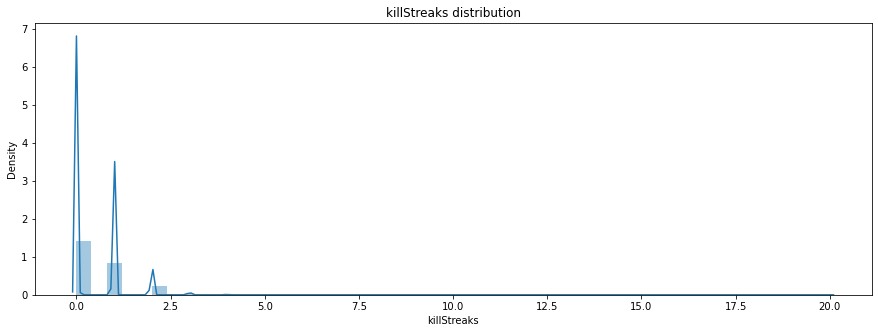

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


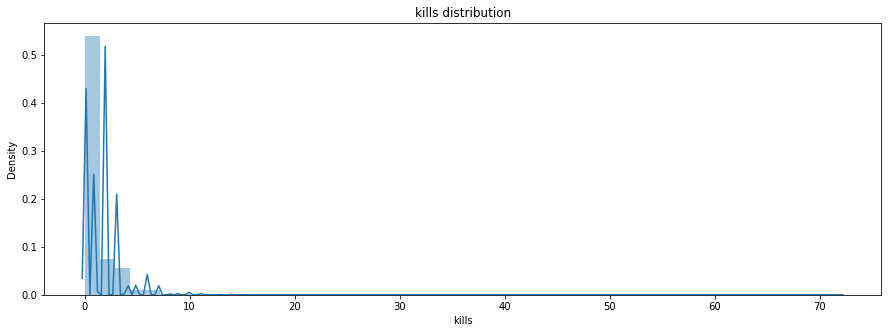

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


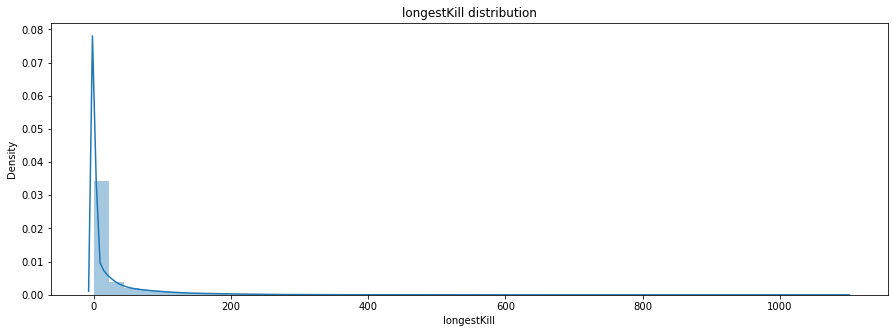

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


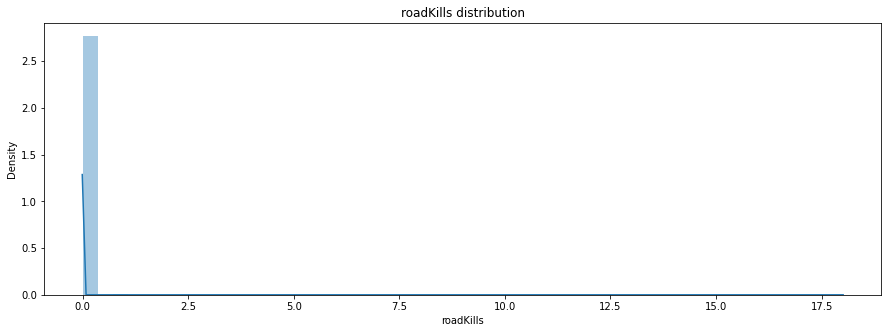

In [263]:
for feature in cols_temp:
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    p = sns.distplot(data[feature], ax=axes)
    axes.set_title(f"{feature} distribution")
    plt.show()

# p = sns.distplot(data['DBNOs'], ax=axes[1])
# axes[1].set_title("distribution - kills <= 10")
# p.set(xlim=(0, 10))

# plt.show()

**INSIGHTS** we cut data after 99th quantile for 
- DBNOs
- killStreaks
- kills
- longestKill
- roadKills (not used to filter data, removing after 99th percentile lead to removal of whole data)

In [45]:
data=data[data['DBNOs']<data['DBNOs'].quantile(0.99)]
display(data.shape)
data=data[data['killStreaks']<data['killStreaks'].quantile(0.99)]
display(data.shape)
data=data[data['kills']<data['kills'].quantile(0.99)]
display(data.shape)
data=data[data['longestKill']<data['longestKill'].quantile(0.99)]
display(data.shape)
# data=data[data['roadKills']<data['roadKills'].quantile(0.99)]
# data.shape

(4384123, 29)

(3993139, 29)

(3912280, 29)

(3873100, 29)

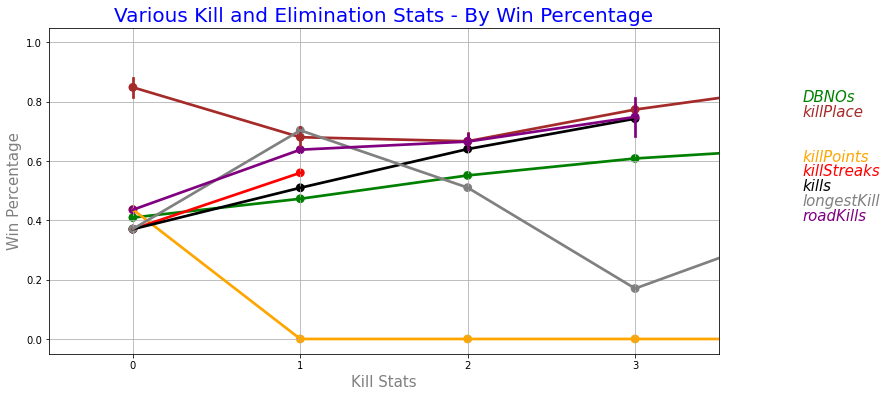

In [46]:
cols_temp = ['DBNOs', 'killPlace', 'killPoints', 'killStreaks', 'kills', 'longestKill', 'roadKills']
f, ax1 = plt.subplots(figsize=(12,6))

sns.pointplot(x='DBNOs',y='winPlacePerc', data=data, color='green', alpha=0.8)
sns.pointplot(x='killPlace',y='winPlacePerc', data=data, color='brown', alpha=0.8)
sns.pointplot(x='killPoints',y='winPlacePerc', data=data, color='orange', alpha=0.8)
sns.pointplot(x='killStreaks',y='winPlacePerc', data=data, color='red', alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc', data=data, color='black', alpha=0.8)
sns.pointplot(x='longestKill',y='winPlacePerc', data=data, color='gray', alpha=0.8)
sns.pointplot(x='roadKills',y='winPlacePerc', data=data, color='purple', alpha=0.8)

plt.text(4, 0.80, 'DBNOs', color='green', fontsize=15, style='italic')
plt.text(4, 0.75, 'killPlace', color='brown', fontsize=15, style='italic')
plt.text(4, 0.60, 'killPoints', color='orange', fontsize=15, style='italic')
plt.text(4, 0.55, 'killStreaks', color='red', fontsize=15, style='italic')
plt.text(4, 0.50, 'kills', color='black', fontsize=15, style='italic')
plt.text(4, 0.45, 'longestKill', color='gray', fontsize=15, style='italic')
plt.text(4, 0.40, 'roadKills', color='purple', fontsize=15, style='italic')

plt.xlabel('Kill Stats', fontsize=15, color='gray')
plt.ylabel('Win Percentage',fontsize=15, color='gray')
plt.title('Various Kill and Elimination Stats - By Win Percentage', fontsize=20, color='blue')
plt.grid()
plt.show()

**INSIGHTS**
- kills, killstreaks, and DBNOs, which are considered main indicators of number of eliminations, have a positive relationship with win percentage.
- Other features don't have a strong correlation with win percentage.
- More games can be won if a player manages to get more eliminations, which requires skill and practice.

### 2.8 Are higher ranked players more capable of winning games?

**Features**: rankPoints

The answer seems like a no-brainer (yes). but we have to check to validite the rank feature for the data, and whether or not it verifies the set hypothesis for it.

In [41]:
data = dfd.copy()
cols_temp = ['rankPoints']

**NOTE** using transformed features as they are more standadized

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


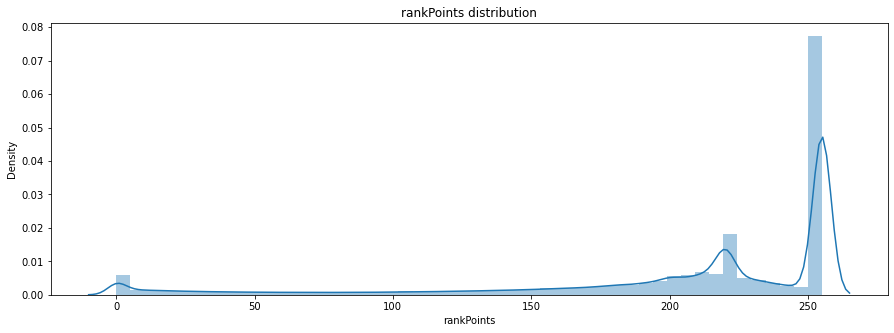

In [267]:
for feature in cols_temp:
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    p = sns.distplot(data[feature], ax=axes)
    axes.set_title(f"{feature} distribution")
    plt.show()

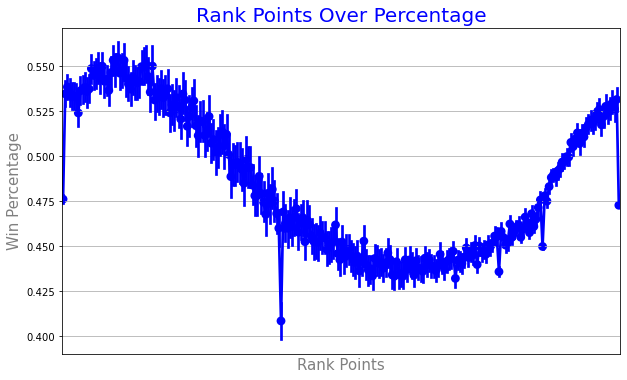

In [42]:
f, ax1 = plt.subplots(figsize=(10,6))

sns.pointplot(x='rankPoints',y='winPlacePerc', data=data, color='blue', alpha=0.8)
# plt.text(4, 0.55, 'rankPoints', color='green', fontsize=15, style='italic')

plt.xlabel('Rank Points', fontsize=15, color='gray')
plt.ylabel('Win Percentage',fontsize=15, color='gray')
plt.title('Rank Points Over Percentage', fontsize=20, color='blue')
plt.grid()
plt.xticks([])
plt.show()

- players initially win a lot of games as they enter rank, starting from low-tiers and climbing to higher tiers
- players get stuck in certain ELOs based on they're skill-level and game-sense
- top-tier players get a high win percentage to maintain their rank. 

### 2.9 Does playing cooperatively with the team contribute to winning more games?

**Features**: teamKills, revives, assists, damageDealt, vehicleDestroys

In [47]:
data = dfd.copy()
cols_temp = ['teamKills', 'revives', 'assists', 'damageDealt', 'vehicleDestroys']

**NOTE** using transformed features as they are more standadized

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


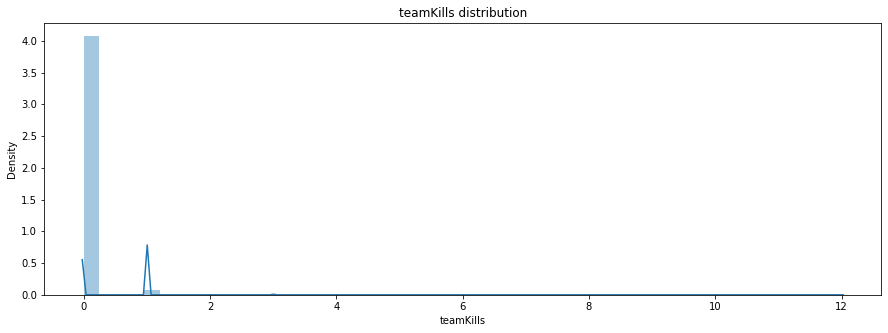

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


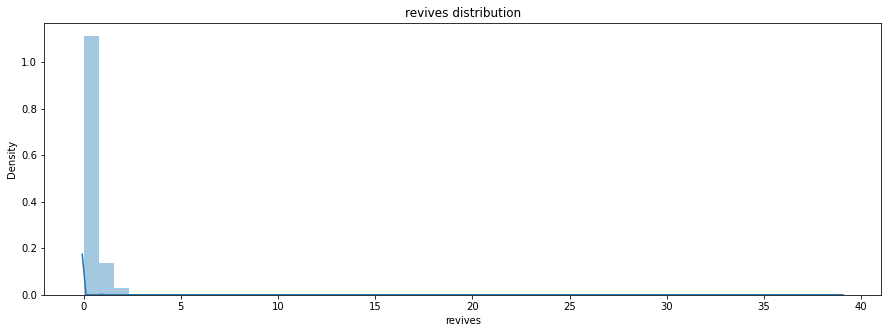

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


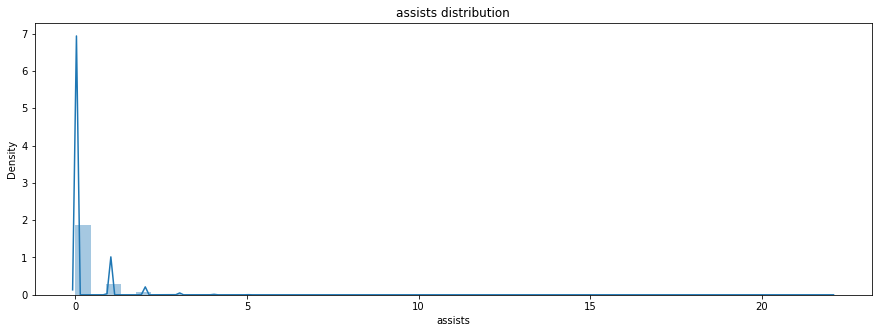

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


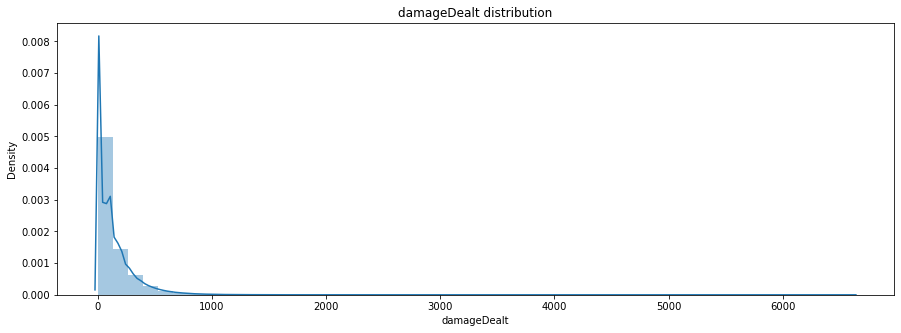

C:\Users\modaj\anaconda3\envs\DataEngineering\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


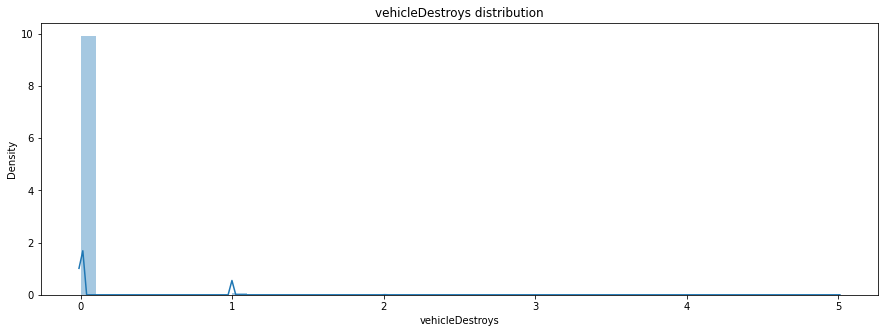

In [270]:
for feature in cols_temp:
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    p = sns.distplot(data[feature], ax=axes)
    axes.set_title(f"{feature} distribution")
    plt.show()

**INSIGHTS** we cut data after 99th quantile for
- teamKills
- revives
- assists
- damageDealt
- vehicleDestroys (not used to filter data, as removing after 99th percentile lead to removal of whole data)

In [271]:
data=data[data['teamKills']<data['teamKills'].quantile(0.99)]
display(data.shape)

data=data[data['revives']<data['revives'].quantile(0.99)]
display(data.shape)

data=data[data['assists']<data['assists'].quantile(0.99)]
display(data.shape)

data=data[data['damageDealt']<data['damageDealt'].quantile(0.99)]
display(data.shape)

# data=data[data['vehicleDestroys']<data['vehicleDestroys'].quantile(0.99)]
# display(data.shape)

(4350035, 30)

(4237644, 30)

(4194803, 30)

(4152851, 30)

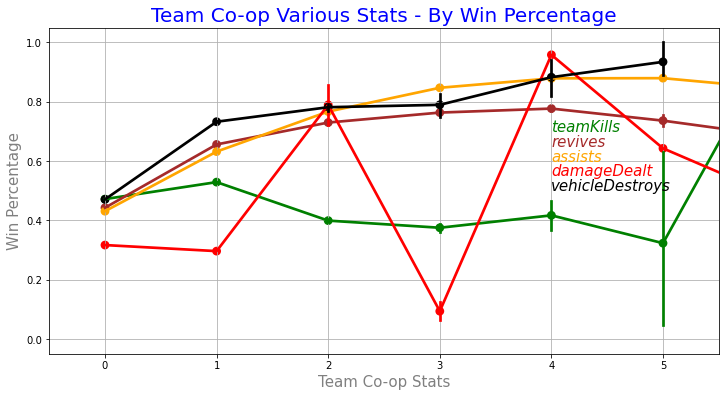

In [43]:
f, ax1 = plt.subplots(figsize=(12,6))

sns.pointplot(x='teamKills',y='winPlacePerc', data=data, color='green', alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc', data=data, color='brown', alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc', data=data, color='orange', alpha=0.8)
sns.pointplot(x='damageDealt',y='winPlacePerc', data=data, color='red', alpha=0.8)
sns.pointplot(x='vehicleDestroys',y='winPlacePerc', data=data, color='black', alpha=0.8)

plt.text(4, 0.70, 'teamKills', color='green', fontsize=15, style='italic')
plt.text(4, 0.65, 'revives', color='brown', fontsize=15, style='italic')
plt.text(4, 0.60, 'assists', color='orange', fontsize=15, style='italic')
plt.text(4, 0.55, 'damageDealt', color='red', fontsize=15, style='italic')
plt.text(4, 0.50, 'vehicleDestroys', color='black', fontsize=15, style='italic')

plt.xlabel('Team Co-op Stats', fontsize=15, color='gray')
plt.ylabel('Win Percentage', fontsize=15, color='gray')
plt.title('Team Co-op Various Stats - By Win Percentage', fontsize=20, color='blue')
plt.grid()
plt.show()

<AxesSubplot:xlabel='teamKills', ylabel='winPlacePerc'>

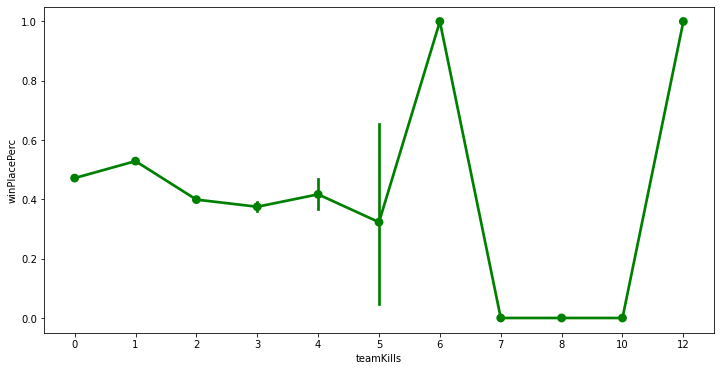

In [48]:
f, ax1 = plt.subplots(figsize=(12,6))

sns.pointplot(x='teamKills',y='winPlacePerc', data=data, color='green', alpha=0.8)

<AxesSubplot:xlabel='damageDealt', ylabel='winPlacePerc'>

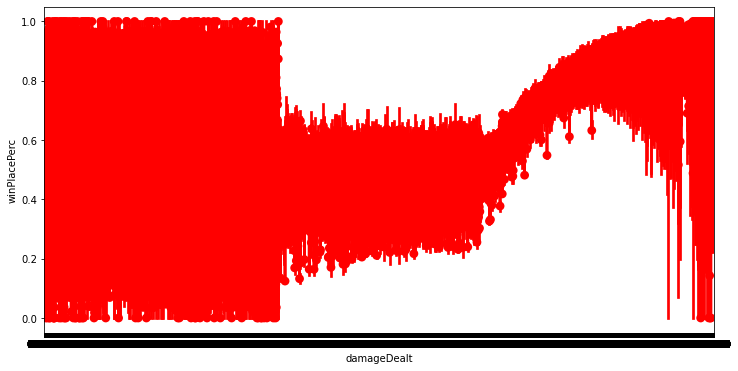

In [49]:
f, ax1 = plt.subplots(figsize=(12,6))

sns.pointplot(x='damageDealt',y='winPlacePerc', data=data, color='red', alpha=0.8)

**INSIGHTS** 
- most stats related to teamwork do imply that the more you contribute, the higher you have chance of winning
- the player has to be close to his during the game, dealing damage, providing assists, and reviving teammates when necessary.
- having a number advantage over other teams is necessary for a higher chance of winning, it is not adviced to play alone (except in solo-matches as it is every individual for themselves)

---

# 3- Recommnedations

#### To win more games you have to:
<ol>
  <li>play more solo games for higher chance of winning or, squad games if you have a team you can coordinate with</li>
  <li>utilize healing and boosting items effectively</li>
  <li>try to practice and develop skills to get more kills and eliminations</li>
  <li>develop your skills as you climb ranks, as the games become harder to win</li>
</ol>

---

# References

- https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
- https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
- https://tutorial.dask.org/01_dataframe.html
- https://stackabuse.com/ultimate-guide-to-heatmaps-in-seaborn-with-python/
- Notebooks: 
    - https://www.kaggle.com/code/inyeongkang/pubg-only-eda
    - https://www.kaggle.com/code/pragya1110/pubg-visualizing-placement-prediction